# Long-Tailed Recognition via Weight Balancing
## Demonstration for the second stage training
CVPR 2022 Submission #0020


## import packages


Some packages are installed automatically if you use Anaconda. There are other packages not included in Anaconda, such as pandas, seaborn, PyTorch, and torchvision. They should be installed properly.

In [1]:
from __future__ import print_function, division
import os, random, time, copy, scipy, pickle, sys, math
from skimage import io, transform
import numpy as np
import os.path as path
import scipy.io as sio
from scipy import misc
from scipy import ndimage, signal
import matplotlib.pyplot as plt
import PIL.Image
from io import BytesIO
from skimage import data, img_as_float

import pandas as pd
import seaborn as sn
import sklearn.metrics 
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

from utils.eval_funcs import *
from utils.dataset_CIFAR100LT import *
from utils.network_arch_resnet import *
from utils.trainval import *
from utils.plot_funcs import *
from utils.regularizers import *
from utils.class_balanced_loss import CB_loss


import warnings # ignore warnings
warnings.filterwarnings("ignore")
print(sys.version)
print(torch.__version__)

3.8.8 (default, Apr 13 2021, 19:58:26) 
[GCC 7.3.0]
1.9.0


## Setup config parameters
 
There are several things to setup, like which GPU to use, model name, hyper-parameters, etc. Please read the comments. By default, you should be able to run this script smoothly without changing anything.

In [2]:
# fix the random seed for fair comparison. 
# NOTE that we also removed "shuffle" lines in generating long-tailed CIFAR already (cf. util.dataset_CIFAR100LT.py)
torch.manual_seed(0)
np.random.seed(0)

In [3]:
# set device, which gpu to use.
device ='cpu'
if torch.cuda.is_available(): 
    device='cuda'

In [4]:
curr_working_dir = os.getcwd()
project_name = 'demo_2'
imb_type = 'exp' # samling long-tailed training set with an exponetially-decaying function
imb_factor = 0.01 # imbalance factor = 100 = 1/0.01
    
nClasses = 100  # number of classes in CIFAR100-LT with imbalance factor 100
encoder_num_layers = 34 # network architecture is ResNet34
batch_size = 64 # batch size 
isPretrained = False

torch.cuda.device_count()
torch.cuda.empty_cache()
save_dir = path.join(curr_working_dir, 'exp', project_name)
if not os.path.exists(save_dir): os.makedirs(save_dir)

log_filename = os.path.join(save_dir, 'train.log')

## setup dataset
download the CIFAR100 dataset if there does not exist one.

In [5]:
path_to_DB = './datasets'
if not os.path.exists(path_to_DB): os.makedirs(path_to_DB)
_ = torchvision.datasets.CIFAR100(root=path_to_DB, train=True, download=True)

Files already downloaded and verified


In [6]:
path_to_DB = path.join(path_to_DB, 'cifar-100-python')

datasets = {}
dataloaders = {}

setname = 'meta'
with open(os.path.join(path_to_DB, setname), 'rb') as obj:
    labelnames = pickle.load(obj, encoding='bytes')
    labelnames = labelnames[b'fine_label_names']
for i in range(len(labelnames)):
    labelnames[i] = labelnames[i].decode("utf-8") 
    
    
setname = 'train'
with open(os.path.join(path_to_DB, setname), 'rb') as obj:
    DATA = pickle.load(obj, encoding='bytes')
imgList = DATA[b'data'].reshape((DATA[b'data'].shape[0],3, 32,32))
labelList = DATA[b'fine_labels']
total_num = len(labelList)
img_num_per_cls = get_img_num_per_cls(nClasses, total_num, imb_type, imb_factor)
new_imgList, new_labelList = gen_imbalanced_data(img_num_per_cls, imgList, labelList)
datasets[setname] = CIFAR100LT(
    imageList=new_imgList, labelList=new_labelList, labelNames=labelnames,
    set_name=setname, isAugment=setname=='train')
print('#examples in {}-set:'.format(setname), datasets[setname].current_set_len)



setname = 'test'
with open(os.path.join(path_to_DB, setname), 'rb') as obj:
    DATA = pickle.load(obj, encoding='bytes')
imgList = DATA[b'data'].reshape((DATA[b'data'].shape[0],3, 32,32))
labelList = DATA[b'fine_labels']
total_num = len(labelList)
datasets[setname] = CIFAR100LT(
    imageList=imgList, labelList=labelList, labelNames=labelnames,
    set_name=setname, isAugment=setname=='train')


print('#examples in {}-set:'.format(setname), datasets[setname].current_set_len)



dataloaders = {set_name: DataLoader(datasets[set_name],
                                    batch_size=batch_size,
                                    shuffle=set_name=='train', 
                                    num_workers=4) # num_work can be set to batch_size
               for set_name in ['train', 'test']} # 'train',



print('#train batch:', len(dataloaders['train']), '\t#test batch:', len(dataloaders['test']))

#examples in train-set: 10847
#examples in test-set: 10000
#train batch: 170 	#test batch: 157


Text(0, 0.5, '#training examples')

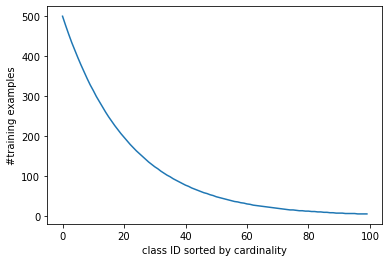

In [7]:
plt.plot(img_num_per_cls)
plt.xlabel('class ID sorted by cardinality')
plt.ylabel('#training examples')

torch.Size([64, 3, 32, 32])


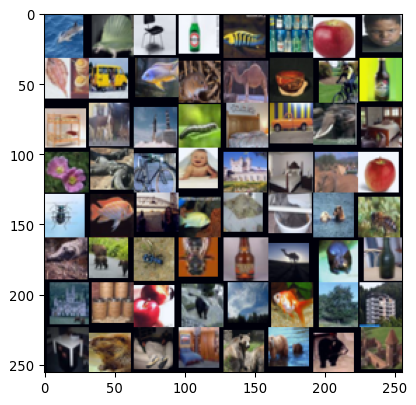

In [8]:
data_sampler = iter(dataloaders['train'])
data = next(data_sampler)
imageList, labelList = data

imageList = imageList.to(device)
labelList = labelList.type(torch.long).view(-1).to(device)

print(imageList.shape)

imList = imageList.permute(0,2,3,1).cpu().numpy()
imList -= imList.min()
imList /= imList.max()+0.0001
imList = createMontage(imList, (32, 32, 64))

fig = plt.figure(figsize=(5,5), dpi=95) # better display with larger figure
plt.imshow(imList)

torch.Size([64, 3, 32, 32])


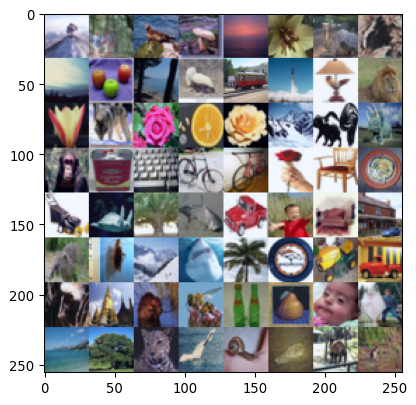

In [9]:
data_sampler = iter(dataloaders['test'])
data = next(data_sampler)
imageList, labelList = data

imageList = imageList.to(device)
labelList = labelList.type(torch.long).view(-1).to(device)

print(imageList.shape)

imList = imageList.permute(0,2,3,1).cpu().numpy()
imList -= imList.min()
imList /= imList.max()+0.0001
imList = createMontage(imList, (32, 32, 64))

fig = plt.figure(figsize=(5,5), dpi=95) # better display with larger figure
plt.imshow(imList)

# Second Stage training 


## Download base model

In [10]:
################## load base model ###################
path_to_model = './exp/demo_1/with_WD_model_best.paramOnly'

base_model = ResnetEncoder(encoder_num_layers, isPretrained, embDimension=nClasses, poolSize=4).to(device)
base_model.load_state_dict(torch.load(path_to_model, map_location=device))
base_model.to(device);

In [11]:
models = {'base': base_model}

In [12]:
print_accuracy(base_model, dataloaders, new_labelList, device = device)

acc avgClass:  47.9%
Many: 78.0% Medium: 46.9% Few: 13.9%


## Applying L2 Normlaization

In [13]:
model = copy.deepcopy(base_model)
L2_norm = Normalizer(tau=1)
L2_norm.apply_on(model)
models['L2 normalized'] = model

In [14]:
print_accuracy(model, dataloaders, new_labelList, device = device)

acc avgClass:  51.0%
Many: 77.0% Medium: 50.3% Few: 21.6%


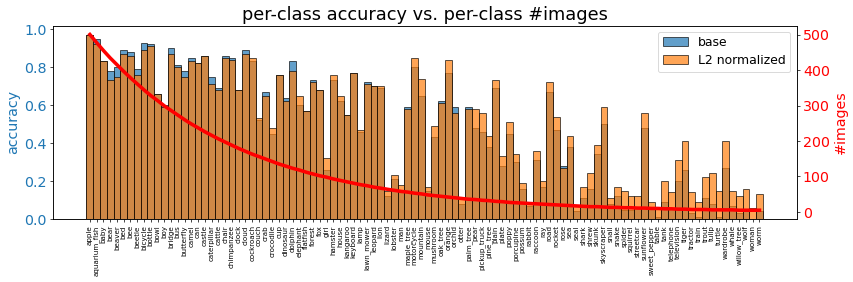

In [15]:
plot_per_class_accuracy(models, dataloaders, labelnames, img_num_per_cls, nClasses= nClasses, device = device)

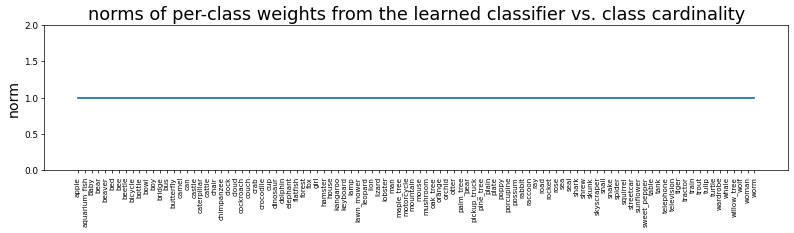

In [16]:
plot_norms(model, labelnames)

## Apply $\tau$-normalization

In [17]:
model = copy.deepcopy(base_model)
tau_norm = Normalizer(tau=1.9)
tau_norm.apply_on(model)
models['tau normalized'] = model

In [18]:
print_accuracy(model, dataloaders, new_labelList, device = device)

acc avgClass:  52.6%
Many: 74.1% Medium: 48.8% Few: 32.0%


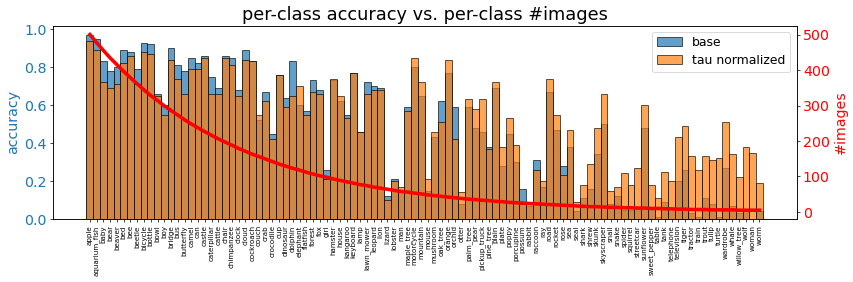

In [19]:
cls_to_compare = {x: models[x] for x in ['base', 'tau normalized']} #dictionary of models we want to compare
plot_per_class_accuracy(cls_to_compare, dataloaders, labelnames, img_num_per_cls, nClasses= nClasses, device = device)

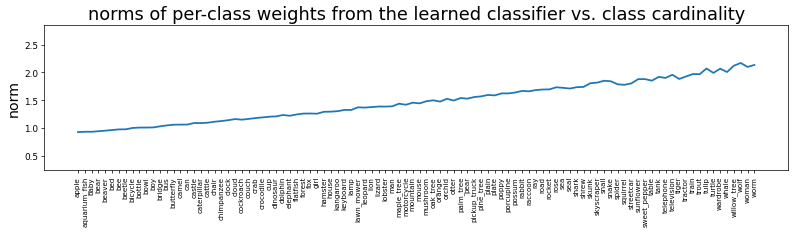

In [20]:
plot_norms(models['tau normalized'], labelnames)

## Finetune with MaxNorm and Weight Decay

In [30]:
model = copy.deepcopy(base_model)
model_name = 'MaxNorm_WD'

thresh = 0.1 #threshold value
pgdFunc = MaxNorm_via_PGD(thresh=thresh)
pgdFunc.setPerLayerThresh(model) # set per-layer thresholds

In [31]:
active_layers = [model.encoder.fc.weight, model.encoder.fc.bias]
for param in model.parameters(): #freez all model paramters except the classifier layer
    param.requires_grad = False
    
for param in active_layers:
    param.requires_grad = True

In [32]:
base_lr = 0.01
total_epoch_num = 10
weight_decay = 0.1 #weight decay value

def CB_lossFunc(logits, labelList): #defince CB loss function
    return CB_loss(labelList, logits, img_num_per_cls, nClasses, "softmax", 0.9999, 2.0, device)

In [33]:
optimizer = optim.SGD([{'params': active_layers, 'lr': base_lr}], lr=base_lr, momentum=0.9, weight_decay=weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, total_epoch_num, eta_min=0.0)
save_dir = path.join(curr_working_dir, 'exp', project_name)

In [34]:
trackRecords = train_model(dataloaders, model, CB_lossFunc, optimizer, scheduler, pgdFunc = pgdFunc,
                           num_epochs=total_epoch_num, device = device, work_dir='./exp/'+project_name, 
                           model_name= model_name)


Epoch 1/10
----------
train
	loss:0.004194, acc-all:0.99982, acc-avg-cls:0.99790
test
	loss:0.051306, acc-all:0.46570, acc-avg-cls:0.46570

Epoch 2/10
----------
train
	loss:0.009930, acc-all:1.00000, acc-avg-cls:1.00000
test
	loss:0.054984, acc-all:0.47010, acc-avg-cls:0.47010

Epoch 3/10
----------
train
	loss:0.011025, acc-all:0.99982, acc-avg-cls:0.99969
test
	loss:0.055617, acc-all:0.49090, acc-avg-cls:0.49090

Epoch 4/10
----------
train
	loss:0.011226, acc-all:0.99945, acc-avg-cls:0.99174
test
	loss:0.055755, acc-all:0.51030, acc-avg-cls:0.51030

Epoch 5/10
----------
train
	loss:0.011272, acc-all:0.99917, acc-avg-cls:0.99138
test
	loss:0.055801, acc-all:0.51330, acc-avg-cls:0.51330

Epoch 6/10
----------
train
	loss:0.011285, acc-all:0.99880, acc-avg-cls:0.99836
test
	loss:0.055812, acc-all:0.51400, acc-avg-cls:0.51400

Epoch 7/10
----------
train
	loss:0.011288, acc-all:0.99852, acc-avg-cls:0.99935
test
	loss:0.055806, acc-all:0.51980, acc-avg-cls:0.51980

Epoch 8/10
--------

In [35]:
# load model with best epoch accuracy
path_to_clsnet = os.path.join(save_dir, model_name+'_best.paramOnly')
model.load_state_dict(torch.load(path_to_clsnet, map_location=device));

model.to(device);
model.eval();
models['MaxNorm WD'] = model

In [36]:
print_accuracy(model, dataloaders, new_labelList, device = device)

acc avgClass:  53.1%
Many: 72.2% Medium: 49.6% Few: 34.9%


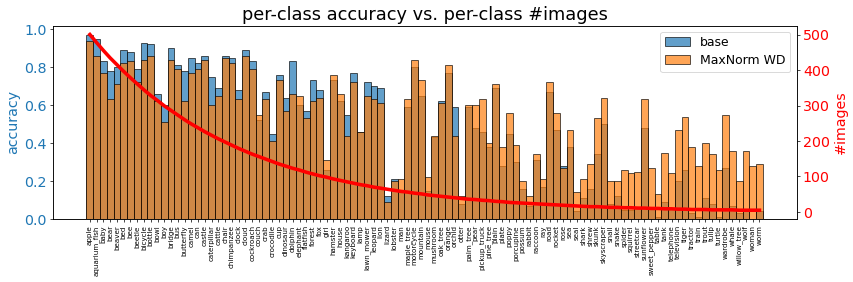

In [37]:
models_to_visualize = {x: models[x] for x in ['base', 'MaxNorm WD']}
plot_per_class_accuracy(models_to_visualize, dataloaders, labelnames, img_num_per_cls, nClasses= nClasses, device = device)

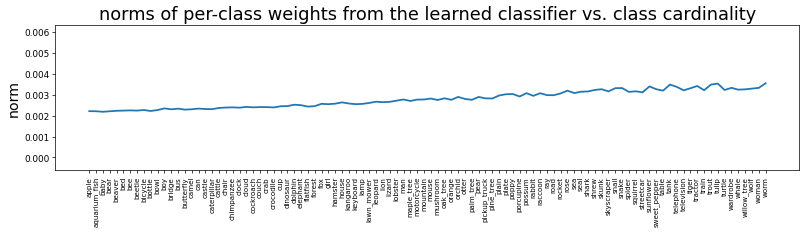

In [38]:
plot_norms(models['MaxNorm WD'], labelnames)